<h3> Goals </h3>

- Prepare household dataset for binary classification
- Create a logistic regression modle to predict severe damage.
- Explain model predictions using odds ratio.
- Interrogate important features based on caste
- Group categorical features which are high cardinal
- Investigate apparent role in caste in building damage.


In [102]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import TargetEncoder

In [103]:
%load_ext sql
%sql sqlite:///./data/nepal.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [104]:
%%sql
SELECT h.*,s.* ,i.vdcmun_id, d.damage_grade
FROM household_demographics AS h
JOIN id_map AS i ON i.household_id = h.household_id
JOIN building_structure AS s ON i.building_id = s.building_id
JOIN building_damage AS d ON i.building_id = d.building_id
WHERE district_id = 4
LIMIT 5

 * sqlite:///./data/nepal.sqlite
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,vdcmun_id,damage_grade
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,164002,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Repaired and used,"Stone, mud mortar",38,Grade 2
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,164081,2,2,21,200,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 2
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,164089,3,3,18,315,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 2
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,164098,2,2,45,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 3
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,164103,2,2,21,230,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 3


In [105]:
%%sql
SELECT name 
FROM sqlite_schema
WHERE type = "table"


 * sqlite:///./data/nepal.sqlite
Done.


name
id_map
building_structure
building_damage
household_demographics


In [106]:
%%sql
SELECT *
FROM building_damage
LIMIT 5

 * sqlite:///./data/nepal.sqlite
Done.


building_id,damage_overall_collapse,damage_overall_leaning,damage_overall_adjacent_building_risk,damage_foundation_severe,damage_foundation_moderate,damage_foundation_insignificant,damage_roof_severe,damage_roof_moderate,damage_roof_insignificant,damage_corner_separation_severe,damage_corner_separation_moderate,damage_corner_separation_insignificant,damage_diagonal_cracking_severe,damage_diagonal_cracking_moderate,damage_diagonal_cracking_insignificant,damage_in_plane_failure_severe,damage_in_plane_failure_moderate,damage_in_plane_failure_insignificant,damage_out_of_plane_failure_severe,damage_out_of_plane_failure_moderate,damage_out_of_plane_failure_insignificant,damage_out_of_plane_failure_walls_ncfr_severe,damage_out_of_plane_failure_walls_ncfr_moderate,damage_out_of_plane_failure_walls_ncfr_insignificant,damage_gable_failure_severe,damage_gable_failure_moderate,damage_gable_failure_insignificant,damage_delamination_failure_severe,damage_delamination_failure_moderate,damage_delamination_failure_insignificant,damage_column_failure_severe,damage_column_failure_moderate,damage_column_failure_insignificant,damage_beam_failure_severe,damage_beam_failure_moderate,damage_beam_failure_insignificant,damage_infill_partition_failure_severe,damage_infill_partition_failure_moderate,damage_infill_partition_failure_insignificant,damage_staircase_severe,damage_staircase_moderate,damage_staircase_insignificant,damage_parapet_severe,damage_parapet_moderate,damage_parapet_insignificant,damage_cladding_glazing_severe,damage_cladding_glazing_moderate,damage_cladding_glazing_insignificant,area_assesed,damage_grade,technical_solution_proposed,has_repair_started,has_damage_foundation,has_damage_roof,has_damage_corner_separation,has_damage_diagonal_cracking,has_damage_in_plane_failure,has_damage_out_of_plane_failure,has_damage_out_of_plane_walls_ncfr_failure,has_damage_gable_failure,has_damage_delamination_failure,has_damage_column_failure,has_damage_beam_failure,has_damage_infill_partition_failure,has_damage_staircase,has_damage_parapet,has_damage_cladding_glazing,has_geotechnical_risk,has_geotechnical_risk_land_settlement,has_geotechnical_risk_fault_crack,has_geotechnical_risk_liquefaction,has_geotechnical_risk_landslide,has_geotechnical_risk_rock_fall,has_geotechnical_risk_flood,has_geotechnical_risk_other
1,Moderate-Heavy,Insignificant/light,None,None,Moderate-Heavy-(<1/3),Insignificant/light-(<1/3),Severe-Extreme-(<1/3),None,Insignificant/light-(>2/3),Severe-Extreme-(>2/3),None,None,Severe-Extreme-(<1/3),None,None,Severe-Extreme-(>2/3),None,None,None,Moderate-Heavy-(>2/3),None,Severe-Extreme-(>2/3),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Both,Grade 3,Major repair,0.0,None,1.0,1.0,1.0,1.0,None,1.0,0.0,0.0,None,None,None,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,Severe-Extreme,Severe-Extreme,Insignificant/light,Severe-Extreme-(>2/3),None,None,Severe-Extreme-(>2/3),None,None,Severe-Extreme-(>2/3),None,None,Severe-Extreme-(>2/3),None,None,Severe-Extreme-(>2/3),None,None,Severe-Extreme-(>2/3),None,None,Severe-Extreme-(>2/3),None,None,None,None,None,Severe-Extreme-(>2/3),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Exterior,Grade 5,Reconstruction,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,None,None,None,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,Moderate-Heavy,Moderate-Heavy,Moderate-Heavy,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),None,None,None,Insignificant/light-(1/3-2/3),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Both,Grade 2,Minor repair,1.0,None,None,None,None,None,None,None,None,None,None,None,None,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,Moderate-Heavy,Moderate-Heavy,Moderate-Heav

- The wrangle function

In [107]:
def wrangle(db_path):
    conn = sqlite3.connect(db_path)
    query = """
        SELECT h.*,s.* ,i.vdcmun_id, d.damage_grade
        FROM household_demographics AS h
        JOIN id_map AS i ON i.household_id = h.household_id
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
        """
    df = pd.read_sql_query(
        query, con=conn, index_col="household_id"
    )
    #Identify Leaky Features
    drop_cols = [col for col in df.columns if "post_eq" in col]

    #Add high cardinality/reduntant column
    drop_cols.append("building_id")

    #Create Binary Target
    # df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["damage_grade"] = df["damage_grade"].str.replace("Grade", "").str.strip().astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    drop_cols.append("damage_grade")

    # Deop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    top_10 = df["caste_household"].value_counts().head(10).index
    df["caste_household"] = df["caste_household"].apply(
        lambda c: c if c in top_10 else "Other"
        )

    df.drop(columns=drop_cols, inplace=True)



    return df

In [108]:
df=wrangle("./data/nepal.sqlite")
df.head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0


In [109]:
print(df.select_dtypes("object").nunique())

gender_household_head              2
caste_household                   11
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64


In [110]:
print(df.select_dtypes("number").nunique())

age_household_head                        99
size_household                            28
is_bank_account_present_in_household       2
age_building                             127
plinth_area_sq_ft                       1194
height_ft_pre_eq                          58
vdcmun_id                                 11
severe_damage                              2
dtype: int64


In [111]:
print(df["caste_household"].unique())

['Chhetree' 'Magar' 'Sarki' 'Kami' 'Newar' 'Brahman-Hill' 'Other'
 'Damai/Dholi' 'Gurung' 'Tamang' 'Kumal']


In [112]:
print(df["caste_household"].value_counts())

caste_household
Gurung          15119
Brahman-Hill    13043
Chhetree         8766
Other            8608
Magar            8180
Sarki            6052
Newar            5906
Kami             3565
Tamang           2396
Kumal            2271
Damai/Dholi      1977
Name: count, dtype: int64


- Group caste column into other categories

In [113]:
# top_10 = df["caste_household"].value_counts().head(10).index
# df["caste_household"].apply(lambda c: c if c in top_10 else "Other")

- Vertical Split
    - We have one more high cardinality feature that is vdcmun_id, we need it in the communication phase when we are communicating results
    - But we do not need it in the training and inference phase. So we will adjust our split accordingly

In [114]:
target = "severe_damage"
X = df.drop(columns=[target, "vdcmun_id"])
y= df[target]

In [115]:
# Check your work
assert X.shape == (75883, 18), f"The shape of `X` should be (75883, 18), not {X.shape}."
assert "vdcmun_id" not in X.columns, "There should be no `'vdcmun_id'` column in `X`."
assert y.shape == (75883,), f"The shape of `y` should be (75883,), not {y.shape}."

- Creating training, validation and testing data

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

#### Building the Model

- Baseline

In [117]:
majority_class, minority_class=y_train.value_counts(normalize=True)

In [118]:
acc_baseline = y_test.value_counts(normalize=True).max()
print("Baseline Accuracy: ", round(acc_baseline,2))

Baseline Accuracy:  0.64


- Iterate

In [119]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True), LogisticRegression(max_iter=3000)
)

In [120]:
model_lr.fit(X_train,y_train)

d:\Data Science\Applied_data_science_lab_worldquant\applied_data_science_labs\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('onehotencoder', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['gender_household_head', 'caste_household', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


In [121]:
acc_train = model_lr.score(X_train,y_train)
acc_test = model_lr.score(X_test,y_test)

print("LR Training Accuracy:", acc_train)
print("LR Validation Accuracy:", acc_test)

LR Training Accuracy: 0.7182980265542122
LR Validation Accuracy: 0.7221453515187455


#### Communicate Results

In [122]:
features = model_lr.named_steps['onehotencoder'].get_feature_names_out()
importances =model_lr.named_steps['logisticregression'].coef_[0]
feat_imp = pd.DataFrame(np.exp(importances), index=features).sort_values(by=0)
feat_imp

,0
foundation_type_RC,0.329436
superstructure_Other,0.331109
"superstructure_Brick, cement mortar",0.409035
plan_configuration_Multi-projected,0.419458
roof_type_RCC/RB/RBC,0.439366
...,...
plan_configuration_Rectangular,1.566015
superstructure_Adobe/mud,2.047986
foundation_type_Other,2.155362
"superstructure_Stone, mud mortar",3.113372


Text(0.5, 0, 'Odds Ratio')

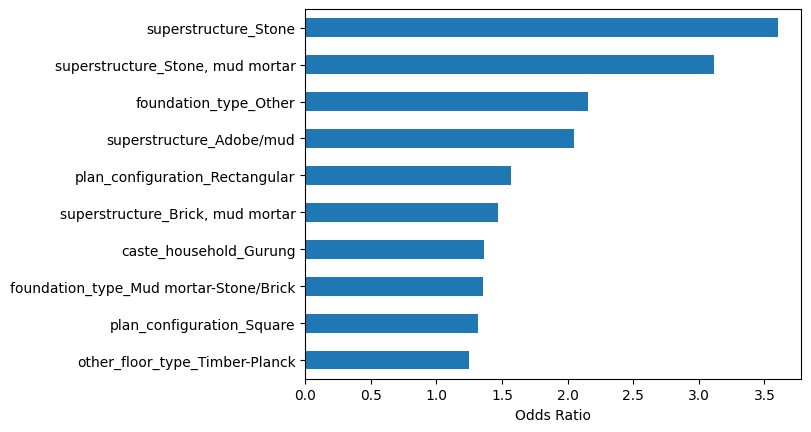

In [123]:
feat_imp.tail(10).plot(kind="barh", legend=None)
plt.xlabel("Odds Ratio")

Text(0.5, 0, 'Odds Ratio')

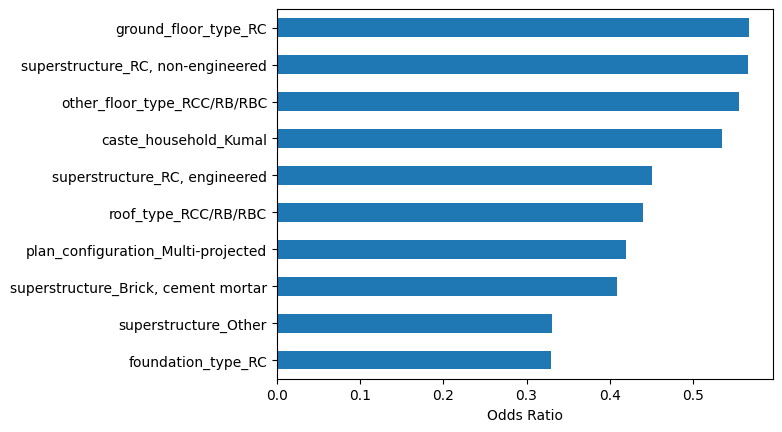

In [124]:
feat_imp.head(10).plot(kind="barh", legend=None)
plt.xlabel("Odds Ratio")

#### Explore more

In [135]:
damage_by_vdcmun = (
    df.groupby("vdcmun_id")["severe_damage"].mean().sort_values(ascending=False)
)
damage_by_vdcmun

vdcmun_id
31    0.930199
32    0.851117
35    0.827145
30    0.824201
33    0.782464
34    0.666979
39    0.572344
40    0.512444
38    0.506425
36    0.503972
37    0.437789
Name: severe_damage, dtype: float64

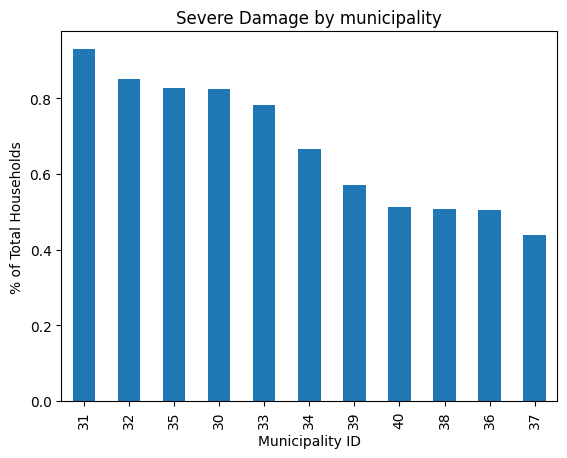

In [136]:
#plot line
damage_by_vdcmun.plot(kind="bar")
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by municipality");

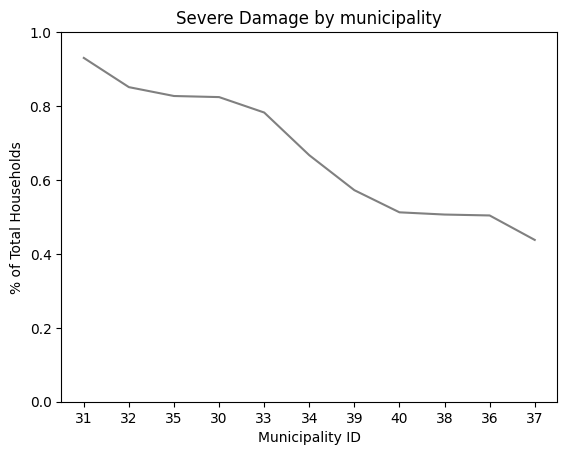

In [137]:
#plot line
plt.plot(damage_by_vdcmun.values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels=damage_by_vdcmun.index)
plt.yticks(np.arange(0.0,1.1,0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by municipality");

In [138]:
df.head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,...,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage,Gurung
household_id,,,,,,,,,,,,,,,,,,,,,
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,20,560,18,...,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0,NaN
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,21,200,12,...,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0,NaN
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,18,315,20,...,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0,NaN
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,45,290,13,...,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0,NaN
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,21,230,13,...,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0,NaN


In [154]:
df2 = (
    df[df["caste_household"]=="Gurung"].groupby("vdcmun_id")["severe_damage"].count()
    /df.groupby("vdcmun_id")["severe_damage"].count()
).to_frame

In [155]:
df2

<bound method Series.to_frame of vdcmun_id
30    0.338152
31    0.326937
32    0.387849
33    0.011943
34    0.385084
35    0.826889
36    0.143178
37    0.050485
38    0.049023
39    0.097971
40    0.246727
Name: severe_damage, dtype: float64>

In [157]:
type(df2)

method

In [156]:
damage_by_vdcmun["Gurung"] = df2["severe_damage"]

TypeError: 'method' object is not subscriptable

In [ ]:
damage_by_vdcmun

vdcmun_id
31                                                 0.930199
32                                                 0.851117
35                                                 0.827145
30                                                 0.824201
33                                                 0.782464
34                                                 0.666979
39                                                 0.572344
40                                                 0.512444
38                                                 0.506425
36                                                 0.503972
37                                                 0.437789
Gurung    <bound method Series.to_frame of vdcmun_id\n30...
Name: severe_damage, dtype: object